# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import gc

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 500

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print("--- Adding new features")
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        # Beware of data leakage
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        dataframe = dataframe.copy()
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

        return dataframe


    def load(self):
        print(f'Loading data')
        
        train = pd.read_csv(self.train_path, index_col='id')
        test = pd.read_csv(self.test_path, index_col='id')
        train['is_train'] = 1
        test['is_train'] = 0
        
        dataframe = pd.concat([train, test])
        del train, test
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        train = dataframe[dataframe['is_train'] == 1].drop(columns=['is_train'])
        test = dataframe[dataframe['is_train'] == 0].drop(columns=['is_train', TARGET])
        del dataframe
        
        train[TARGET] = train[TARGET].astype(int)
        
        return train, test

In [4]:
train, test = DataLoader(TRAIN_PATH, TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 2486.95 MB
------ Memory usage after: 621.74 MB
------ Decreased memory usage by 75.0%


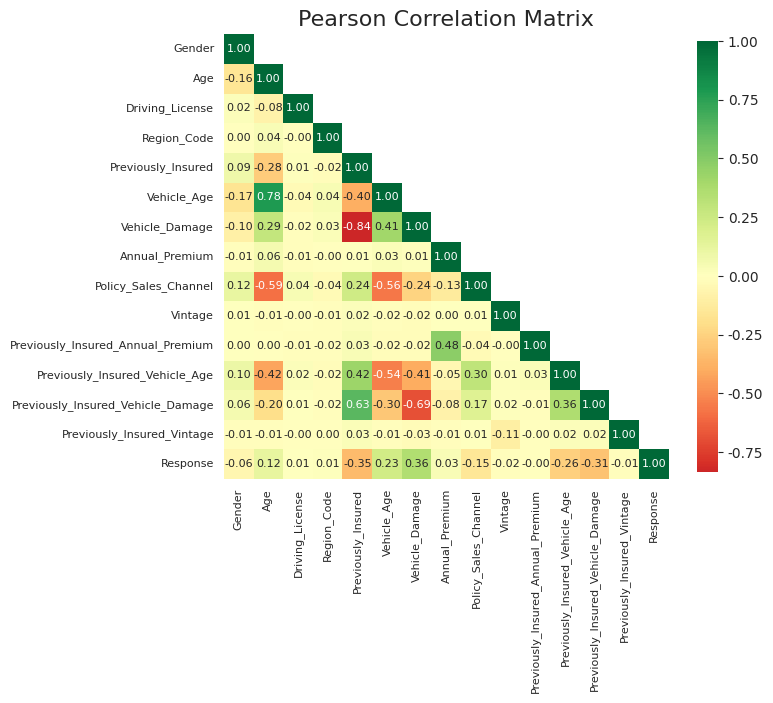

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 8))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

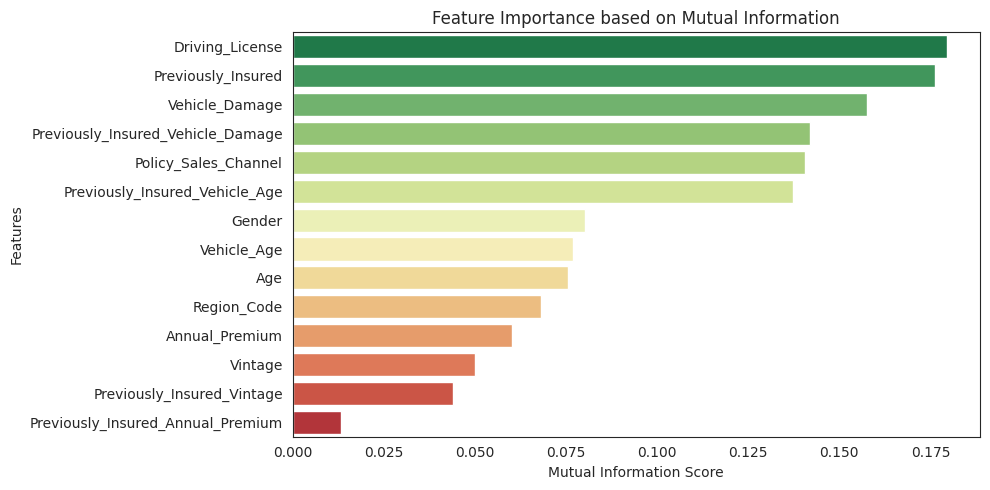

In [6]:
train_mi = train.copy()
train_mi = train_mi.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])

plt.figure(figsize=(10, 5))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        eval_history = []
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_pool = Pool(X_train, y_train, cat_features=X_train.columns.values)
            val_pool = Pool(X_val, y_val, cat_features=X_val.columns.values)
            test_pool = Pool(X_test, cat_features=X_test.columns.values)
            
            model = clone(self.model)
            model.fit(
                X=train_pool, 
                eval_set=val_pool, 
                verbose=ES_LOG_STEPS, 
                early_stopping_rounds=ES_ROUNDS,
                use_best_model=True
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            eval_history.append(model.get_evals_result())
            
            y_pred_probs = model.predict_proba(val_pool)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(test_pool)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            del model
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances, eval_history
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        sub['id'] = sub['id']
        sub[TARGET] = np.mean(test_preds, axis=0)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
params = {
    'iterations': 5000,
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'random_state': SEED
}

model = CatBoostClassifier(**params)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances, eval_history = trainer.fit_predict(X, y, test)

Training CatBoostClassifier

Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8664761	best: 0.8664761 (0)	total: 9.3s	remaining: 12h 54m 39s
500:	test: 0.8912786	best: 0.8912786 (500)	total: 7m 27s	remaining: 1h 6m 59s
1000:	test: 0.8928791	best: 0.8928791 (1000)	total: 14m 38s	remaining: 58m 30s
1500:	test: 0.8935061	best: 0.8935061 (1500)	total: 21m 42s	remaining: 50m 36s
2000:	test: 0.8938408	best: 0.8938408 (2000)	total: 28m 46s	remaining: 43m 7s
2500:	test: 0.8940639	best: 0.8940639 (2500)	total: 35m 46s	remaining: 35m 45s
3000:	test: 0.8942294	best: 0.8942294 (3000)	total: 42m 47s	remaining: 28m 30s
3500:	test: 0.8943551	best: 0.8943551 (3500)	total: 49m 50s	remaining: 21m 20s
4000:	test: 0.8944516	best: 0.8944516 (4000)	total: 56m 51s	remaining: 14m 11s
4500:	test: 0.8945372	best: 0.8945372 (4500)	total: 1h 3m 52s	remaining: 7m 4s
4999:	test: 0.8946062	best: 0.8946062 (4999)	total: 1h 10m 54s	remaining: 0us
bestTest = 0.894606173
bestIteration = 4999

--- Fold 1 - AUC: 0.89461


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8663457	best: 0.8663457 (0)	total: 890ms	remaining: 1h 14m 10s
500:	test: 0.8913048	best: 0.8913048 (500)	total: 7m 21s	remaining: 1h 6m 2s
1000:	test: 0.8928752	best: 0.8928752 (1000)	total: 14m 30s	remaining: 57m 58s
1500:	test: 0.8935156	best: 0.8935156 (1500)	total: 21m 38s	remaining: 50m 26s
2000:	test: 0.8938748	best: 0.8938748 (2000)	total: 28m 42s	remaining: 43m 1s
2500:	test: 0.8941048	best: 0.8941048 (2500)	total: 35m 48s	remaining: 35m 46s
3000:	test: 0.8942638	best: 0.8942638 (3000)	total: 42m 55s	remaining: 28m 35s
3500:	test: 0.8943727	best: 0.8943727 (3500)	total: 49m 57s	remaining: 21m 23s
4000:	test: 0.8944722	best: 0.8944722 (4000)	total: 57m 4s	remaining: 14m 14s
4500:	test: 0.8945528	best: 0.8945528 (4500)	total: 1h 4m 4s	remaining: 7m 6s
4999:	test: 0.8946162	best: 0.8946162 (4999)	total: 1h 11m 8s	remaining: 0us
bestTest = 0.8946162164
bestIteration = 4999

--- Fold 2 - AUC: 0.89462


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8663059	best: 0.8663059 (0)	total: 889ms	remaining: 1h 14m 1s
500:	test: 0.8913228	best: 0.8913228 (500)	total: 7m 19s	remaining: 1h 5m 49s
1000:	test: 0.8929043	best: 0.8929043 (1000)	total: 14m 33s	remaining: 58m 8s
1500:	test: 0.8935305	best: 0.8935305 (1500)	total: 21m 41s	remaining: 50m 34s
2000:	test: 0.8938722	best: 0.8938722 (2000)	total: 28m 45s	remaining: 43m 6s
2500:	test: 0.8940768	best: 0.8940768 (2500)	total: 35m 50s	remaining: 35m 49s
3000:	test: 0.8942339	best: 0.8942339 (3000)	total: 42m 53s	remaining: 28m 34s
3500:	test: 0.8943650	best: 0.8943650 (3500)	total: 49m 57s	remaining: 21m 23s
4000:	test: 0.8944650	best: 0.8944650 (4000)	total: 56m 57s	remaining: 14m 13s
4500:	test: 0.8945528	best: 0.8945528 (4500)	total: 1h 4m 1s	remaining: 7m 5s
4999:	test: 0.8946210	best: 0.8946210 (4999)	total: 1h 11m 4s	remaining: 0us
bestTest = 0.8946210146
bestIteration = 4999

--- Fold 3 - AUC: 0.89462


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8665928	best: 0.8665928 (0)	total: 890ms	remaining: 1h 14m 6s
500:	test: 0.8912602	best: 0.8912602 (500)	total: 7m 19s	remaining: 1h 5m 47s
1000:	test: 0.8927986	best: 0.8927986 (1000)	total: 14m 31s	remaining: 58m
1500:	test: 0.8933863	best: 0.8933863 (1500)	total: 21m 39s	remaining: 50m 29s
2000:	test: 0.8937221	best: 0.8937221 (2000)	total: 28m 43s	remaining: 43m 2s
2500:	test: 0.8939403	best: 0.8939403 (2499)	total: 35m 48s	remaining: 35m 46s
3000:	test: 0.8940994	best: 0.8940994 (3000)	total: 42m 52s	remaining: 28m 33s
3500:	test: 0.8942244	best: 0.8942244 (3500)	total: 49m 53s	remaining: 21m 21s
4000:	test: 0.8943177	best: 0.8943177 (3999)	total: 56m 53s	remaining: 14m 12s
4500:	test: 0.8943962	best: 0.8943962 (4500)	total: 1h 3m 57s	remaining: 7m 5s
4999:	test: 0.8944639	best: 0.8944639 (4999)	total: 1h 10m 59s	remaining: 0us
bestTest = 0.8944638968
bestIteration = 4999

--- Fold 4 - AUC: 0.89446


Learning rate set to 0.016835


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8654970	best: 0.8654970 (0)	total: 888ms	remaining: 1h 14m
500:	test: 0.8908588	best: 0.8908588 (500)	total: 7m 21s	remaining: 1h 6m 2s
1000:	test: 0.8924682	best: 0.8924682 (1000)	total: 14m 34s	remaining: 58m 13s
1500:	test: 0.8931195	best: 0.8931195 (1500)	total: 21m 38s	remaining: 50m 25s
2000:	test: 0.8934616	best: 0.8934616 (2000)	total: 28m 43s	remaining: 43m 3s
2500:	test: 0.8936942	best: 0.8936942 (2500)	total: 35m 49s	remaining: 35m 47s
3000:	test: 0.8938684	best: 0.8938684 (3000)	total: 42m 55s	remaining: 28m 35s
3500:	test: 0.8939854	best: 0.8939854 (3500)	total: 49m 57s	remaining: 21m 23s
4000:	test: 0.8940942	best: 0.8940942 (4000)	total: 56m 59s	remaining: 14m 13s
4500:	test: 0.8941802	best: 0.8941802 (4500)	total: 1h 4m 1s	remaining: 7m 5s
4999:	test: 0.8942568	best: 0.8942568 (4999)	total: 1h 11m 2s	remaining: 0us
bestTest = 0.8942567706
bestIteration = 4999

--- Fold 5 - AUC: 0.89426


------ Average AUC:      0.89451 ± 0.00014




# Visualizing The Results

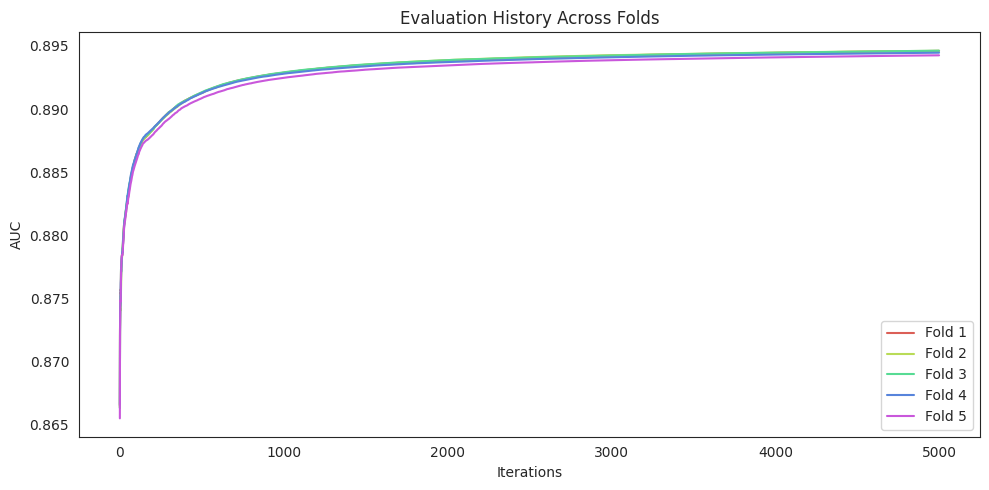

In [9]:
data = []
for fold_idx, fold_eval_history in enumerate(eval_history):
    for metric, values in fold_eval_history['validation'].items():
        if metric != 'AUC':
            continue
        for iteration, auc_value in enumerate(values):
            data.append({'Fold': f'Fold {fold_idx + 1}', 'Metric': metric, 'Iteration': iteration, 'AUC': auc_value})
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Iteration', y='AUC', hue='Fold', palette='hls')
plt.title('Evaluation History Across Folds')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

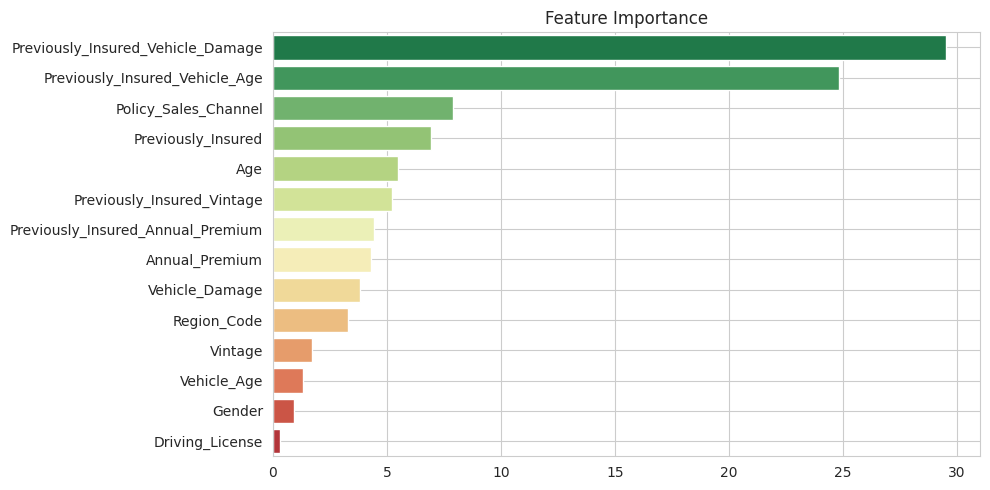

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

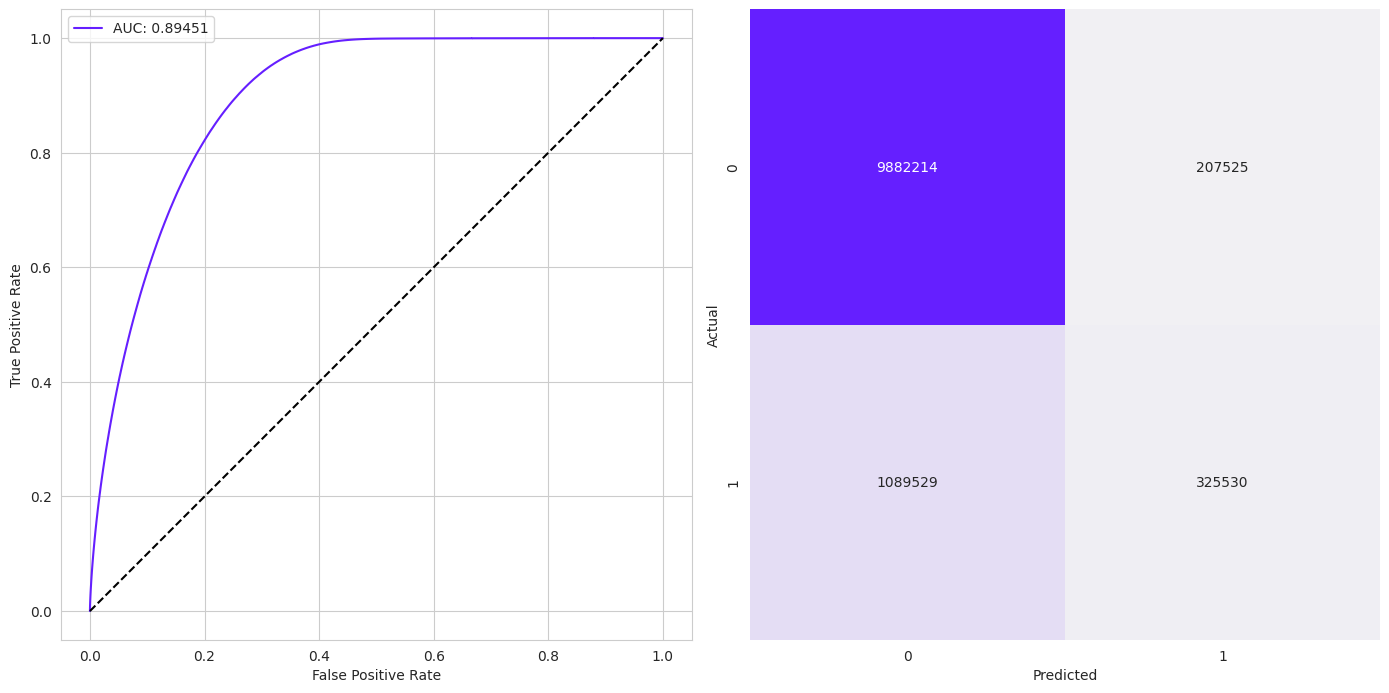

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()